# **Exploratory Data Analysis 1: Crop Yields**
Our first goal is to explore the relationships between the yields of three of the primary crops: maize, soybean, and wheat. We will load the data for each, combine them into a single dataset based on their geographic location (latitude and longitude), and then generate a scatterplot matrix to visualize how the yields of these crops correlate with one another.


In [22]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import os

# Optional: Set a nice style for the plots
sns.set_theme(style="ticks")

## **Step 1: Load and Prepare the Data**

In [23]:
def load_and_clean_crop_data(path_pattern):
    """
    Loads, cleans, and prepares a single crop's data for analysis.
    """
    filepaths = sorted(glob.glob(path_pattern))
    if not filepaths: return None
        
    ds = xr.open_mfdataset(filepaths, combine='nested', concat_dim='time')
    years = [int(re.search(r'(\d{4})\.nc4$', f).group(1)) for f in filepaths]
    ds = ds.assign_coords(time=years)
    mean_ds = ds.mean(dim='time')
    df = mean_ds.to_dataframe().reset_index()
    df = df.dropna(subset=['var'])
    return df

print("Setup complete. Helper function is ready.")

# Define the relative path to your desired output folder
output_dir = '../reports/figures/scatterplot_matrices/'

# Create the directory if it doesn't already exist
os.makedirs(output_dir, exist_ok=True)

print(f"Setup complete. Figures will be saved to: {output_dir}")

Setup complete. Helper function is ready.
Setup complete. Figures will be saved to: ../reports/figures/scatterplot_matrices/


Loading data for maize...
Loading data for soybean...
Loading data for wheat...

Found 3821 locations where all selected crops are grown.
Generating focused scatterplot matrix...


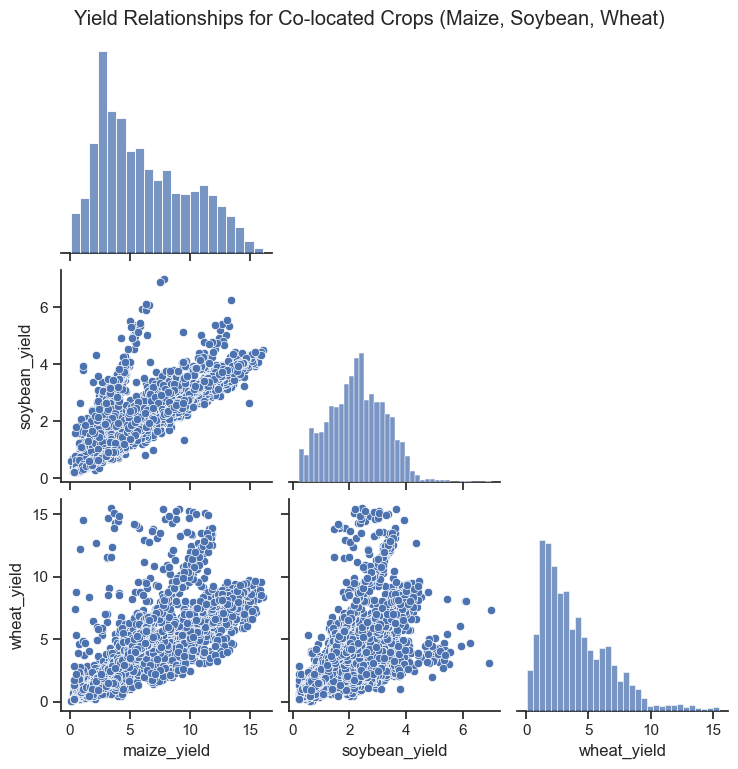

In [24]:
# Cell 2 (Revised): Load, Merge, and Plot a CONTROLLED Matrix

# --- Configuration ---
crops_to_compare = {
    'maize':   '../data/maize/*.nc4',
    'soybean': '../data/soybean/*.nc4',
    'wheat':   '../data/wheat/*.nc4'
}

# --- Load the data for the selected crops ---
crop_dfs = []
for crop, path in crops_to_compare.items():
    print(f"Loading data for {crop}...")
    df = load_and_clean_crop_data(path)
    if df is not None:
        df = df.rename(columns={'var': f'{crop}_yield'})
        crop_dfs.append(df[['lat', 'lon', f'{crop}_yield']])

# --- Merge the DataFrames ---
if crop_dfs:
    merged_df = crop_dfs[0]
    for i in range(1, len(crop_dfs)):
        merged_df = pd.merge(merged_df, crop_dfs[i], on=['lat', 'lon'], how='inner')

    print(f"\nFound {len(merged_df)} locations where all selected crops are grown.")
    print("Generating focused scatterplot matrix...")

    # --- THE FIX IS HERE ---
    # 1. Define the specific columns and their desired order for the plot.
    #    This excludes 'lat' and 'lon'.
    yield_columns = ['maize_yield', 'soybean_yield', 'wheat_yield']

    # 2. Use the 'vars' parameter to tell pairplot exactly what to plot.
    g = sns.pairplot(merged_df, vars=yield_columns, corner=True)
    
    g.fig.suptitle("Yield Relationships for Co-located Crops (Maize, Soybean, Wheat)", y=1.02)
    plt.show()
    g.savefig(os.path.join(output_dir, 'high_overlap_maize_soy_wheat.png'), dpi=300, bbox_inches='tight')
else:
    print("No data was loaded. Please check your file paths.")

## Analysis of the Scatterplot Matrix
This scatterplot matrix provides a powerful overview of the average yields for Maize, Soybean, and Wheat in locations where all three are grown. It allows us to explore both the individual characteristics of each crop's yield and the relationships between them.

### How to Read This Plot
The matrix is composed of two types of plots:
- **Histograms (on the diagonal)**: The plots running down the center from top-left to bottom-right are histograms. Each histogram shows the distribution of a single variable. It helps us understand the range of yields and identify the most common yield values for that specific crop.
- **Scatterplots (off the diagonal)**: All other plots are scatterplots that show the relationship between two different variables. To read a scatterplot, find its corresponding variable on the bottom x-axis (for the column) and the left y-axis (for the row).

### Key Observations and Insights
From this visualization, we can draw several important conclusions:

1. Strong Positive Correlation between Maize and Soybean Yields:
The scatterplot in the second row, first column (Soybean vs. Maize) shows a clear and relatively tight upward trend. This indicates a strong positive correlation. In simple terms, geographic locations that produce high yields of maize also tend to produce high yields of soybeans. This aligns with common agricultural knowledge, as these crops are often grown in rotation in the same fertile regions (like the U.S. Corn Belt).
2. Weaker, More Complex Relationship with Wheat:
The relationships between Wheat and the other two crops (bottom row) are also positive but are much more scattered or "noisy." This suggests that while there is a general trend for yields to rise together, the connection is not as direct as it is between maize and soybean. The wheat_yield vs. maize_yield plot even shows a few distinct clusters, which could suggest different climate sub-regions or farming systems where the relationship between these two crops varies.
3. Different Yield Distributions:
The histograms on the diagonal are very revealing:
    - Maize and Wheat show a similar right-skewed distribution. This means that for both crops, most locations have low-to-moderate yields, with a long "tail" of a few locations producing very high yields.
    - Soybean shows a more normal (bell-shaped) distribution. The yields are more symmetrically clustered around a central average, with fewer extreme high or low values compared to the other crops.

### Summary
The most prominent feature of this analysis is the strong synergistic relationship between maize and soybean yields in co-located areas. Wheat also benefits from similar conditions but appears to have a more complex relationship, suggesting it may have a wider or different range of optimal growing conditions even within these shared regions.

# **Exploratory Data Analysis 2: Wheat seasonality**

**Scientific Question:** How do the yields of winter and spring wheat relate to each other and to their geographic location? Are they grown in the same places? Is one variety inherently higher-yielding?

From what we know about wheat growing, the reason we see both winter and spring harvests is because depending on the seasonality, countries either plant their wheat in the spring, and harvest in the fall, or countries plant their wheat in the winter, where it stays dormant until the winter is over, and then grows in the spring. 

--- Starting Wheat Seasonality Analysis ---
Loading data for wheat_winter...
Loading data for wheat_spring...

Found 12749 total locations for winter and/or spring wheat.
Generating scatterplot matrix...


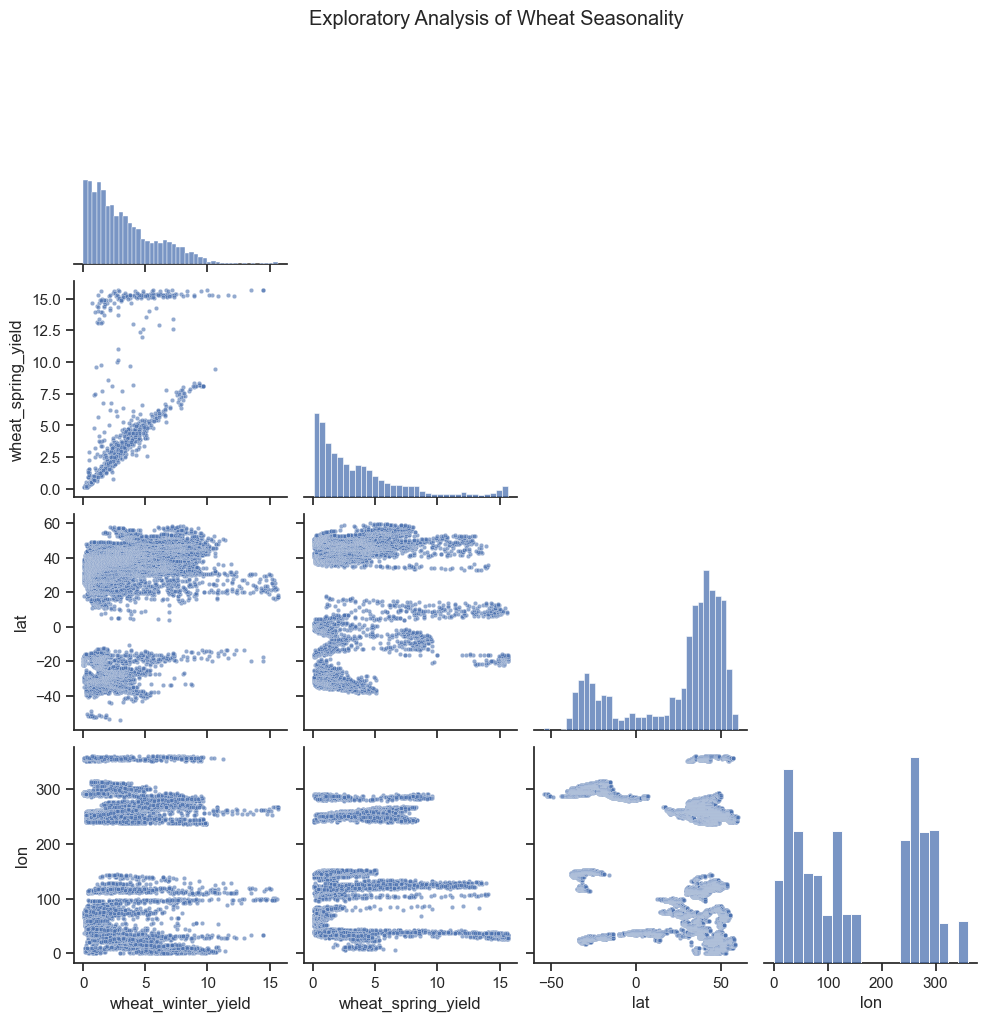

In [25]:
# Cell 3: Generate the Wheat Seasonality Scatterplot Matrix

print("--- Starting Wheat Seasonality Analysis ---")

# --- Configuration ---
# Define the paths for the two wheat varieties
wheat_seasonality_paths = {
    'wheat_winter': '../data/wheat_winter/*.nc4',
    'wheat_spring': '../data/wheat_spring/*.nc4'
}

# --- Load the data for the selected crops ---
seasonal_dfs = []
for crop, path in wheat_seasonality_paths.items():
    print(f"Loading data for {crop}...")
    df = load_and_clean_crop_data(path)
    if df is not None:
        df = df.rename(columns={'var': f'{crop}_yield'})
        seasonal_dfs.append(df)

# --- Merge the DataFrames ---
# We use an 'outer' merge here. This is crucial because we want to keep all
# locations where EITHER winter or spring wheat is grown, not just the few
# locations where they might overlap. This allows us to see the full
# geographic range of each variety. Missing values will be filled with NaN.
if len(seasonal_dfs) == 2:
    wheat_merged_df = pd.merge(seasonal_dfs[0], seasonal_dfs[1], on=['lat', 'lon'], how='outer')

    print(f"\nFound {len(wheat_merged_df)} total locations for winter and/or spring wheat.")
    print("Generating scatterplot matrix...")

    # --- Create the Scatterplot Matrix ---
    # We explicitly include 'lat' and 'lon' as they are key to our analysis.
    # Seaborn's pairplot is smart enough to handle the NaN values, only plotting
    # the available data points in each subplot.
    vars_to_plot = ['wheat_winter_yield', 'wheat_spring_yield', 'lat', 'lon']
    
    g = sns.pairplot(wheat_merged_df, vars=vars_to_plot, corner=True,
                     plot_kws={'s': 10, 'alpha': 0.6}) # Add styling for better visibility
    
    g.fig.suptitle("Exploratory Analysis of Wheat Seasonality", y=1.02)
    plt.show()
    g.savefig(os.path.join(output_dir, 'wheat_seasonality_deep_dive.png'), dpi=300, bbox_inches='tight')

else:
    print("Could not load data for both wheat varieties. Please check file paths.")

## Key Observations and Insights

This scatterplot matrix reveales an interesting relationship between the spring and winter wheat. As expected, we see some seasonality depicted in the data, however, interestingly, we see a strong correlation with the two seasons, as well as a large overlap in area. 

1. Strong Overall Positive Correlation:
The most immediate finding is the strong positive correlation between wheat_spring_yield and wheat_winter_yield. The clear upward trend in their scatterplot (second row, first column) indicates that, on the whole, locations with high productivity for one variety also tend to have high productivity for the other. This suggests they thrive under similar soil and climate conditions in the regions where they coexist.
2. Distinct Geographic Niches Revealed by Latitude:
While the general cultivation zones overlap, the plots of yield vs. latitude (lat) reveal critical differences that contradict the idea of an identical distribution:
    - A Tropical Zone for Spring Wheat: There is a clear gap in wheat_winter_yield data around the equator (latitude 0). In contrast, wheat_spring_yield shows a distinct cluster of cultivation in this tropical band. This is a key finding: the lack of a cold winter makes only spring wheat viable in these regions.
    - Bimodal Temperate Zones: The histogram for lat is "bimodal" (has two peaks), confirming major cultivation zones in both the Northern and Southern Hemispheres. It is within these large temperate regions that the two crops overlap most significantly.
3. Winter Wheat Dominance in Key Longitudes:
The plots of yield vs. longitude (lon) further refine the story. While the patterns are similar, the data for wheat_winter_yield is visibly denser and more continuous across major agricultural belts (e.g., longitudes corresponding to the Americas and Eurasia). This suggests that while spring wheat is also grown, winter wheat is the dominant variety in these core temperate zones.

**Conclusion** 
The analysis tells a story of both coexistence and specialization. The strong overall correlation is driven by the large temperate regions where both varieties are productive. However, the exceptions are just as important: spring wheat holds a unique advantage in the tropics, while winter wheat is the primary variety in the established temperate-zone wheat belts. The data shows that rather than being simple substitutes, each variety has a unique environmental edge at the margins of their growing regions.

# **Exploratory Data Analysis 3: Major vs Second Harvest of Rice and Maize**

This analysis helps us understand the dynamics of multi-season cropping. 

**Scientific Question:** In areas that support a second harvest, is there a relationship between the yield of the main harvest and the second one? Is a second harvest only viable in certain latitudes?

## Maize - Major vs. Second Harvest 

This analysis focuses on maize to understand the relationship between the primary and secondary harvests. We will investigate how the yields relate to each other and how the practice of a second harvest is constrained by geography.

--- Starting Maize Harvest Analysis ---
Loading data for maize_major...
Loading data for maize_second...

Found 3018 locations that support both a major and second maize harvest.
Generating scatterplot matrix...


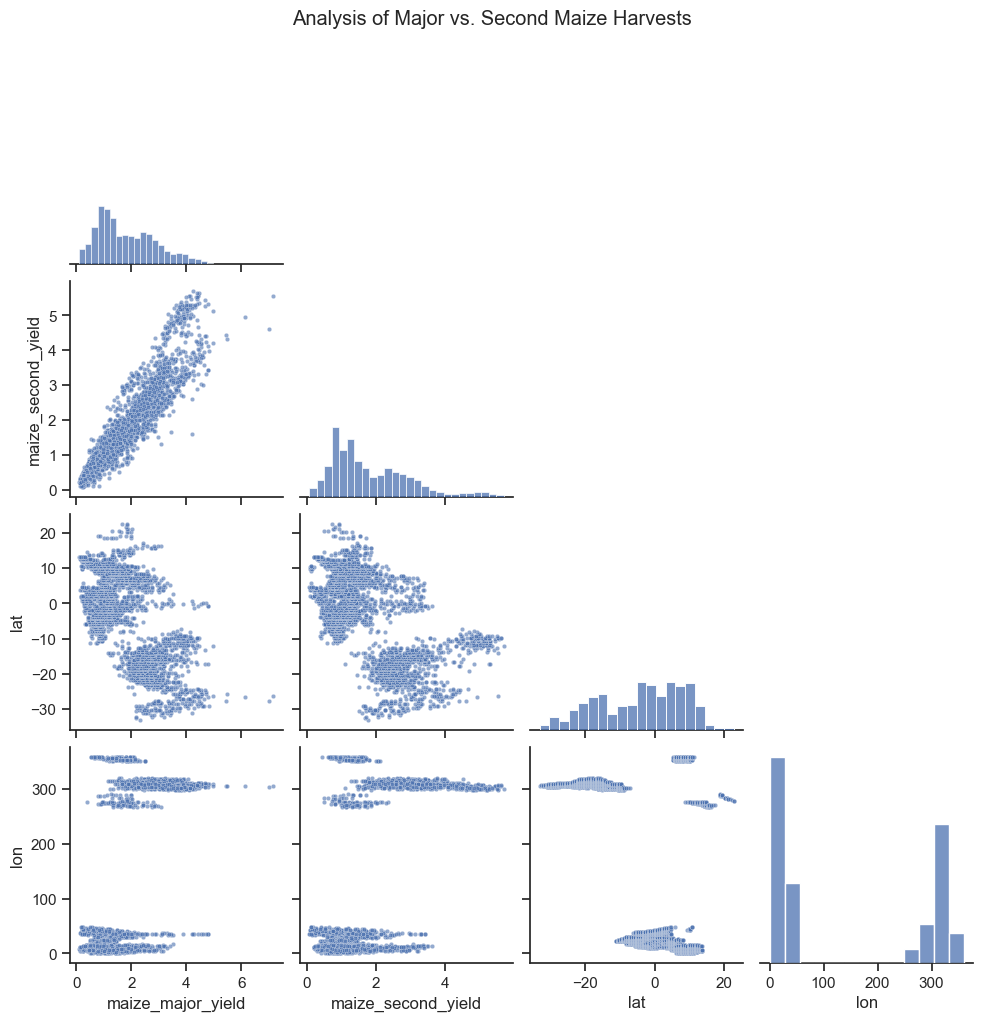

In [26]:
# Cell 4: Generate the Maize Major vs. Second Harvest Matrix

print("--- Starting Maize Harvest Analysis ---")

# --- Configuration ---
maize_harvest_paths = {
    'maize_major':  '../data/maize_major/*.nc4',
    'maize_second': '../data/maize_second/*.nc4'
}

# --- Load the data ---
maize_harvest_dfs = []
for crop, path in maize_harvest_paths.items():
    print(f"Loading data for {crop}...")
    df = load_and_clean_crop_data(path)
    if df is not None:
        df = df.rename(columns={'var': f'{crop}_yield'})
        maize_harvest_dfs.append(df)

# --- Merge the DataFrames ---
# We use an 'inner' merge here because our scientific question is about the
# relationship between the two harvests *in the specific areas that support both*.
if len(maize_harvest_dfs) == 2:
    maize_merged_df = pd.merge(maize_harvest_dfs[0], maize_harvest_dfs[1], on=['lat', 'lon'], how='inner')

    print(f"\nFound {len(maize_merged_df)} locations that support both a major and second maize harvest.")
    print("Generating scatterplot matrix...")

    # --- Create the Scatterplot Matrix ---
    vars_to_plot = ['maize_major_yield', 'maize_second_yield', 'lat', 'lon']
    
    g = sns.pairplot(maize_merged_df, vars=vars_to_plot, corner=True,
                     plot_kws={'s': 10, 'alpha': 0.6})
    
    g.fig.suptitle("Analysis of Major vs. Second Maize Harvests", y=1.02)
    plt.show()
    g.savefig(os.path.join(output_dir, 'multicrop_maize_major_vs_second.png'), dpi=300, bbox_inches='tight')

else:
    print("Could not load data for both maize harvest types. Please check file paths.")

## Rice - Major vs. Second Harvest 

This analysis focuses on maize to understand the relationship between the primary and secondary harvests. We will investigate how the yields relate to each other and how the practice of a second harvest is constrained by geography.

--- Starting Rice Harvest Analysis ---
Loading data for rice_major...
Loading data for rice_second...

Found 1583 locations that support both a major and second rice harvest.
Generating scatterplot matrix...


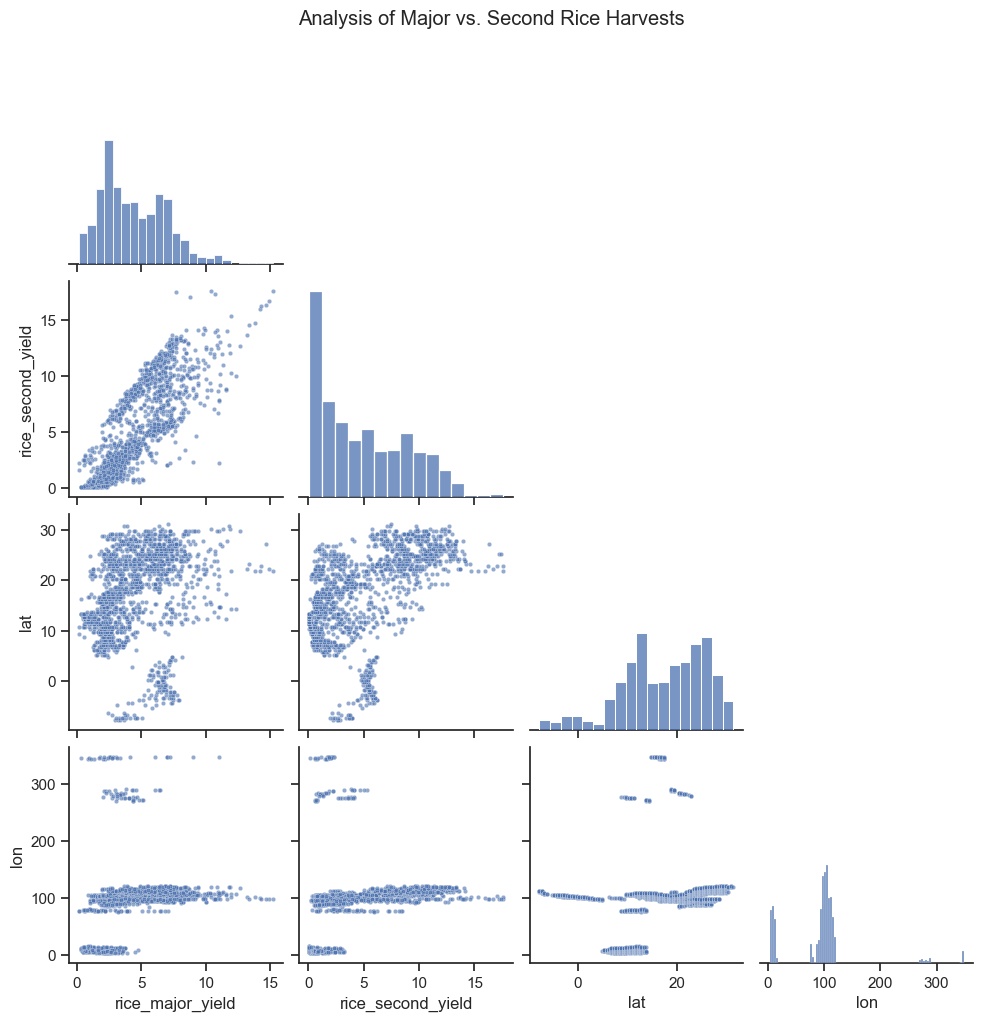

In [27]:
# Cell 5: Generate the Rice Major vs. Second Harvest Matrix

print("--- Starting Rice Harvest Analysis ---")

# --- Configuration ---
rice_harvest_paths = {
    'rice_major':  '../data/rice_major/*.nc4',
    'rice_second': '../data/rice_second/*.nc4'
}

# --- Load the data ---
rice_harvest_dfs = []
for crop, path in rice_harvest_paths.items():
    print(f"Loading data for {crop}...")
    df = load_and_clean_crop_data(path)
    if df is not None:
        df = df.rename(columns={'var': f'{crop}_yield'})
        rice_harvest_dfs.append(df)

# --- Merge the DataFrames ---
if len(rice_harvest_dfs) == 2:
    rice_merged_df = pd.merge(rice_harvest_dfs[0], rice_harvest_dfs[1], on=['lat', 'lon'], how='inner')

    print(f"\nFound {len(rice_merged_df)} locations that support both a major and second rice harvest.")
    print("Generating scatterplot matrix...")

    # --- Create the Scatterplot Matrix ---
    vars_to_plot = ['rice_major_yield', 'rice_second_yield', 'lat', 'lon']
    
    g = sns.pairplot(rice_merged_df, vars=vars_to_plot, corner=True,
                     plot_kws={'s': 10, 'alpha': 0.6})
    
    g.fig.suptitle("Analysis of Major vs. Second Rice Harvests", y=1.02)
    plt.show()
    g.savefig(os.path.join(output_dir, 'multicrop_rice_major_vs_second.png'), dpi=300, bbox_inches='tight')

else:
    print("Could not load data for both rice harvest types. Please check file paths.")


## Analysis of plots

### Analysis of the Maize Plot
- Yield Relationship: The scatterplot of maize_second_yield vs. maize_major_yield shows a very strong, clear positive correlation. In places that support two harvests, a good main harvest strongly predicts a good second harvest.
- The Crucial Latitude Insight: Look at the lat vs. yield plots and the lat histogram. The entire dataset of multi-crop maize exists almost exclusively between -30 and +30 degrees latitude. This is the answer to the second part of our question. It visually proves that a second maize harvest is a tropical and subtropical phenomenon. You cannot do this in the temperate zones of the US or Europe because the growing season is too short.

### Analysis of the Rice Plot
- Yield Relationship: Like maize, the rice plot shows a strong positive correlation between the major and second harvests.
- The Crucial Latitude Insight: The geographic constraint is even more dramatic for rice. The data is almost entirely clustered between 0 and +30 degrees latitude. This tells us that multi-season rice cultivation is overwhelmingly a Northern Hemisphere tropical practice, which corresponds perfectly with the major rice-growing regions of South and Southeast Asia. The lon plot confirms this, showing a heavy concentration around 80-120 degrees longitude.

**Conclusion**
The inner merge correctly isolated the phenomenon we wanted to study (multi-cropping), and the inclusion of lat and lon was the key to understanding the powerful geographic constraints that govern it. The plots demonstrate that having a second harvest isn't just about farming technique; it's a possibility that is only open to specific regions of the world.

# **Exploratory Data Analysis 4: Low regional overlap crop comparison**

**Scientific Question:** In the specific, limited regions where both Wheat and Rice are cultivated (e.g., Northern India, parts of China), is there any discernible relationship between their yields?



--- Starting Low-Overlap Regional Analysis: Rice-Wheat System ---
Loading data for rice...
Loading data for wheat...

Found 3729 total co-located Rice/Wheat points globally.
Filtered down to 662 points within the Indo-Gangetic Plain region.


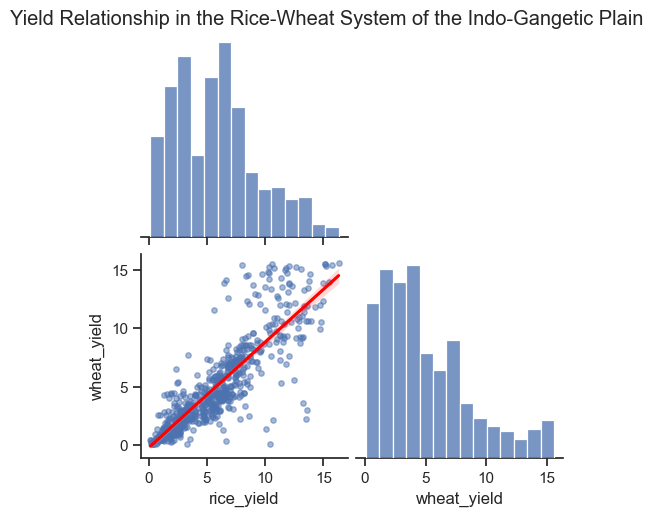

In [28]:
# Cell 6: Low-Overlap Regional Analysis (Rice-Wheat System)

print("--- Starting Low-Overlap Regional Analysis: Rice-Wheat System ---")

# --- Configuration ---
low_overlap_paths = {
    'rice':   '../data/rice/yield_*.nc4',
    'wheat':  '../data/wheat/yield_*.nc4'
}

# --- Load the data ---
low_overlap_dfs = []
for crop, path in low_overlap_paths.items():
    print(f"Loading data for {crop}...")
    df = load_and_clean_crop_data(path)
    if df is not None:
        df = df.rename(columns={'var': f'{crop}_yield'})
        low_overlap_dfs.append(df)

# --- Merge to find all co-located points globally ---
if len(low_overlap_dfs) == 2:
    # First, find all locations on Earth where both are grown
    global_overlap_df = pd.merge(low_overlap_dfs[0], low_overlap_dfs[1], on=['lat', 'lon'], how='inner')
    print(f"\nFound {len(global_overlap_df)} total co-located Rice/Wheat points globally.")

    # --- NEW STEP: Filter to a specific region of interest ---
    # We define a bounding box for the Indo-Gangetic Plain (Northern India, Pakistan, etc.)
    # This is the most prominent orange area on your map.
    lat_min, lat_max = 20, 35
    lon_min, lon_max = 70, 120

    regional_df = global_overlap_df[
        (global_overlap_df['lat'].between(lat_min, lat_max)) &
        (global_overlap_df['lon'].between(lon_min, lon_max))
    ]
    print(f"Filtered down to {len(regional_df)} points within the Indo-Gangetic Plain region.")

    # --- Create the Scatterplot Matrix for the specific region ---
    if len(regional_df) > 0:
        vars_to_plot = ['rice_yield', 'wheat_yield'] # Keep it focused on the yields
        
        g = sns.pairplot(regional_df, vars=vars_to_plot, corner=True, kind='reg',
                         plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.5, 's': 15}})
        
        g.fig.suptitle("Yield Relationship in the Rice-Wheat System of the Indo-Gangetic Plain", y=1.02)
        plt.show()
        g.savefig(os.path.join(output_dir, 'regional_rice_wheat_indo_gangetic.png'), dpi=300, bbox_inches='tight')
    else:
        print("No overlapping data points were found within the specified regional filter.")
else:
    print("Could not load data for both Rice and Wheat. Please check file paths.")

## Analysis of the Indo-Gangetic Plain Rice-Wheat System
This scatterplot matrix provides a focused look into the yield dynamics of the intensive Rice-Wheat agricultural system in the Indo-Gangetic Plain. By filtering to this specific region, we can analyze the relationship between the two cornerstone crops.

**Key Observations and Insights**
1. Strong Positive Correlation: The most prominent feature is the clear positive correlation between rice_yield and wheat_yield, illustrated by the upward trend of the data points and the fitted red regression line. This indicates that the productivity of the two crops is linked. In general, a location and year that produce a high rice yield are also likely to produce a high wheat yield in the subsequent season. This suggests that shared underlying factors—such as well-managed irrigation, soil health, fertilizer availability, and favorable policies—are primary drivers of success for the entire system.
2. Increasing Variance at Higher Yields (Heteroscedasticity): A more subtle and powerful insight comes from the changing shape of the data cloud. The points are tightly clustered in the lower-left corner (low yields) and become significantly more spread out in the upper-right (high yields). This pattern is known as heteroscedasticity.
Interpretation: At lower productivity levels, both crops are likely constrained by the same fundamental limitations (e.g., water scarcity, poor soil), resulting in little variation. However, in high-productivity scenarios where these basic needs are met, other, more variable factors—such as the adoption of advanced high-yield seed varieties, precision farming techniques, or slight variations in weather—begin to dominate. This introduces more variance, explaining why some high-yield rice locations produce exceptionally high wheat yields while others produce more moderate wheat yields.
3. Right-Skewed Yield Distributions: The histograms on the diagonal for both rice and wheat show a distinct right skew (or positive skew). This means the distributions have a long "tail" extending to the right.
    - Interpretation: This shape reveals that for both crops within this system, the majority of locations produce low-to-moderate yields. A smaller number of highly productive, optimized locations are responsible for the highest yields, creating the tail of the distribution. This provides important context for the scatterplot, explaining why the data is densest in the lower-left quadrant.

**Summary**

In conclusion, the analysis reveals a synergistic but complex relationship between rice and wheat in the Indo-Gangetic Plain. While their success is broadly linked, the system's behavior changes as productivity increases, becoming more variable. This suggests that while foundational improvements can lift the entire system, achieving elite-level yields for both crops is a more complex challenge influenced by a wider range of factors.

--- Starting Low-Overlap Regional Analysis: Andean Rice-Wheat System ---
Filtered down to 544 points within the Andean region.


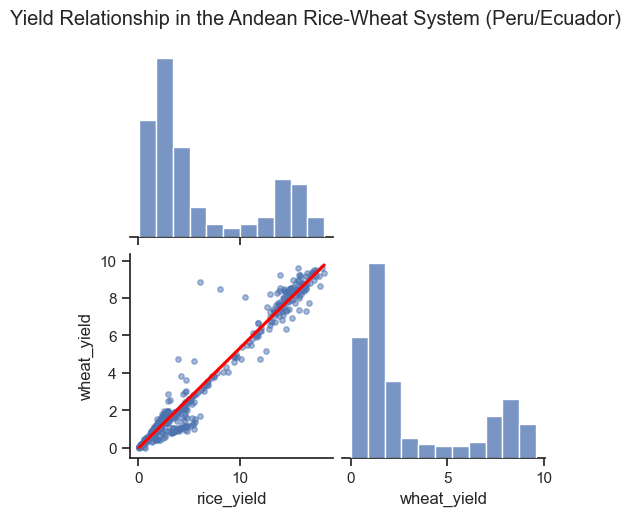

In [29]:
# Cell 7 (Corrected): Low-Overlap Regional Analysis (Andean Rice-Wheat System)

print("--- Starting Low-Overlap Regional Analysis: Andean Rice-Wheat System ---")

if 'global_overlap_df' in locals():
    # --- Filter to the Andean region (Peru/Ecuador) with CORRECTED coordinates ---
    # Define a bounding box for the Andean region.
    # NOTE: We convert longitude to the 0-360 degree system to match the data.
    lat_min, lat_max = -20, 5     # Latitude remains the same
    lon_min, lon_max = 275, 300   # CORRECTED Longitude for Western South America

    andean_regional_df = global_overlap_df[
        (global_overlap_df['lat'].between(lat_min, lat_max)) &
        (global_overlap_df['lon'].between(lon_min, lon_max))
    ]
    print(f"Filtered down to {len(andean_regional_df)} points within the Andean region.")

    # --- Create the Scatterplot Matrix for this specific region ---
    if len(andean_regional_df) > 0:
        vars_to_plot = ['rice_yield', 'wheat_yield']
        
        g = sns.pairplot(andean_regional_df, vars=vars_to_plot, corner=True, kind='reg',
                         plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.5, 's': 15}})
        
        g.fig.suptitle("Yield Relationship in the Andean Rice-Wheat System (Peru/Ecuador)", y=1.02)
        plt.show()
        g.savefig(os.path.join(output_dir, 'regional_rice_wheat_andean.png'), dpi=300, bbox_inches='tight')
    else:
        print("No overlapping data points were found within the specified Andean regional filter.")
else:
    print("Please run the previous cell first to generate 'global_overlap_df'.")

## Analysis of the Andean Rice-Wheat System (Peru/Ecuador)

This analysis of the Andean Rice-Wheat system reveals a fascinating and complex picture, starkly different from the Indo-Gangetic Plain. The data strongly suggests we are observing two distinct agricultural sub-systems within the same geographic filter.

**Key Observations and Insights**
1. A Tale of Two Systems: While the overall regression line shows a strong positive correlation, the most significant feature is the separation of the data into two distinct clusters. There is a dense, lower-yield cluster and a more diffuse, high-yield cluster, connected by a sparse line of data points. This strongly suggests the presence of a confounding variable, likely geography, separating two different farming systems. A leading hypothesis is that these represent high-altitude mountain agriculture (lower yields) and irrigated coastal plain agriculture (higher yields).
2. Bimodal ("U-Shaped") Distributions: This "two-system" hypothesis is powerfully confirmed by the histograms on the diagonal. Both rice_yield and wheat_yield exhibit a bimodal distribution (having two peaks), which you aptly described as "U-shaped." This indicates that for both crops, there are large numbers of locations producing low-to-moderate yields and another large group producing high yields, with very few in between. This is the statistical signature of two different populations being plotted together.
3. Distinct Cluster Characteristics: The shapes of the two clusters are also informative. The lower-yield cluster displays a "fan shape" (heteroscedasticity), where variability increases with yield. In contrast, the high-yield "hypercarry" cluster is more cohesive, perhaps indicating more standardized and consistently high-output commercial farming practices in the most productive zones.

**Summary**

Unlike the continuous system seen in the Indo-Gangetic Plain, the Andean Rice-Wheat system is characterized by a distinct duality. The relationship between rice and wheat yields is still positive within each sub-system, but the existence of two different production environments (likely driven by altitude) is the dominant story. This analysis highlights the critical importance of regional context and demonstrates how a single scatterplot matrix can uncover deep structural patterns in the data.